In [14]:
import os
import json
import cv2
import numpy as np
def load_data(data_folder):
    images = []
    valence_labels = []
    arousal_labels = []

    # Loop over each set of videos (e.g., 01, 02)
    for set_folder in os.listdir(data_folder):
        set_path = os.path.join(data_folder, set_folder)

        # Loop over each individual video folder (e.g., 001, 002)
        for video_folder in os.listdir(set_path):
            video_path = os.path.join(set_path, video_folder)

            # Construct the JSON filename based on the video_folder name
            json_file = video_folder + '.json'

            # Load JSON annotations
            with open(os.path.join(video_path, json_file), 'r') as f:
                annotations = json.load(f)

            # Loop over each frame in the video based on annotations
            for frame, details in annotations['frames'].items():
                frame_path = os.path.join(video_path, frame + '.png')

                # Load the image
                img = cv2.imread(frame_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                # Resize the image to 64x64
                dim = (64, 64)
                resized_img = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)

                # Append the resized image to the images list
                images.append(resized_img)

                # Load valence and arousal values
                valence_labels.append(details['valence'])
                arousal_labels.append(details['arousal'])

    images = np.array(images)
    valence_labels = np.array(valence_labels)
    arousal_labels = np.array(arousal_labels)

    return images, valence_labels, arousal_labels


In [15]:
data_folder = "D:/dataset"
images, valence_labels, arousal_labels = load_data(data_folder)

In [16]:
def preprocess_data(images):
    # Normalize images
    images_normalized = images / 255.0
    return images_normalized

images_normalized = preprocess_data(images)


In [17]:
from sklearn.model_selection import train_test_split

labels = np.column_stack((valence_labels, arousal_labels))

X_train, X_temp, y_train, y_temp = train_test_split(images_normalized, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [18]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.callbacks import EarlyStopping

model = Sequential()

# Convolution layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Fully connected layers
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2))  # 2 outputs: valence and arousal scores

model.compile(optimizer='adam', loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)


In [19]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, callbacks=[early_stopping])


Epoch 1/100
658/658 [==============================] - 57s 82ms/step - loss: 4.8382 - val_loss: 1.7275
Epoch 2/100
658/658 [==============================] - 56s 85ms/step - loss: 1.3343 - val_loss: 0.8356
Epoch 3/100
658/658 [==============================] - 55s 83ms/step - loss: 0.9191 - val_loss: 0.6231
Epoch 4/100
658/658 [==============================] - 54s 83ms/step - loss: 0.7785 - val_loss: 0.5460
Epoch 5/100
658/658 [==============================] - 55s 83ms/step - loss: 0.6959 - val_loss: 0.4600
Epoch 6/100
658/658 [==============================] - 55s 83ms/step - loss: 0.6559 - val_loss: 0.4033
Epoch 7/100
658/658 [==============================] - 55s 83ms/step - loss: 0.6175 - val_loss: 0.3862
Epoch 8/100
658/658 [==============================] - 55s 83ms/step - loss: 0.5917 - val_loss: 0.3574
Epoch 9/100
658/658 [==============================] - 55s 83ms/step - loss: 0.5596 - val_loss: 0.3237
Epoch 10/100
658/658 [==============================] - 55s 83ms/step - l

In [20]:
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")

141/141 [==============================] - 2s 15ms/step - loss: 0.2229
Test Loss: 0.22292368113994598


141/141 [==============================] - 2s 16ms/step


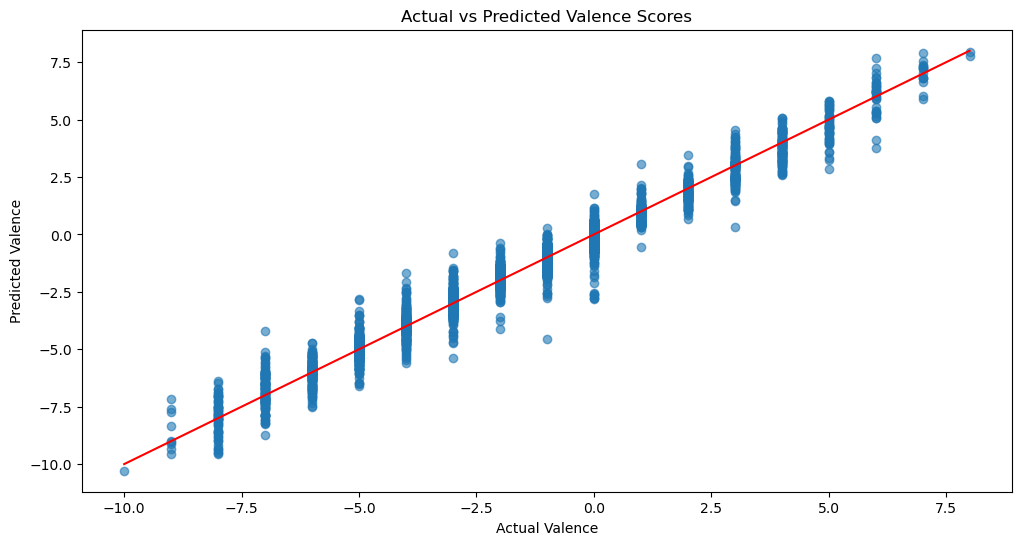

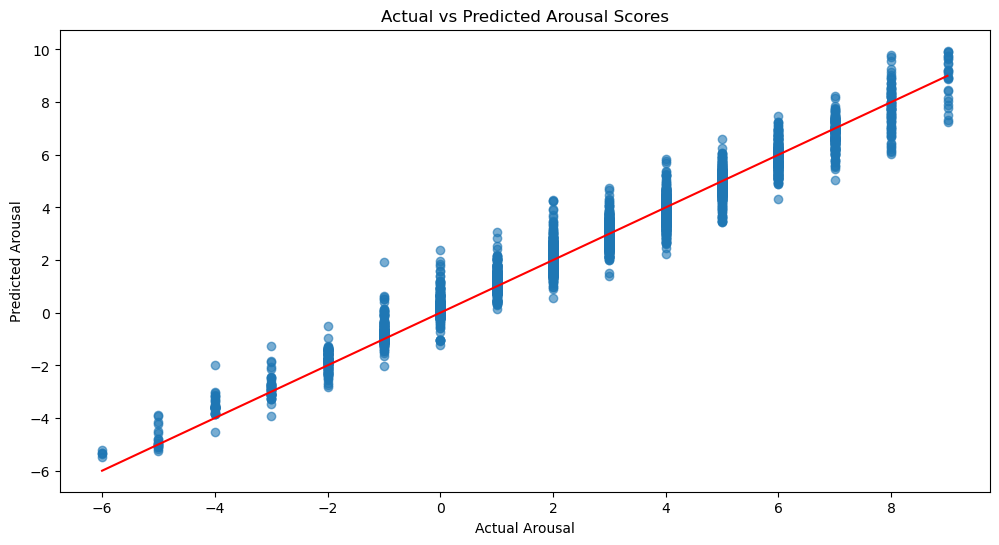

In [21]:
import matplotlib.pyplot as plt

# Predictions on the test set
y_pred = model.predict(X_test)

# Plotting Valence scores
plt.figure(figsize=(12, 6))
plt.scatter(y_test[:, 0], y_pred[:, 0], alpha=0.6)
plt.title('Actual vs Predicted Valence Scores')
plt.xlabel('Actual Valence')
plt.ylabel('Predicted Valence')
plt.plot([min(y_test[:, 0]), max(y_test[:, 0])], [min(y_test[:, 0]), max(y_test[:, 0])], color='red') # y=x line
plt.show()

# Plotting Arousal scores
plt.figure(figsize=(12, 6))
plt.scatter(y_test[:, 1], y_pred[:, 1], alpha=0.6)
plt.title('Actual vs Predicted Arousal Scores')
plt.xlabel('Actual Arousal')
plt.ylabel('Predicted Arousal')
plt.plot([min(y_test[:, 1]), max(y_test[:, 1])], [min(y_test[:, 1]), max(y_test[:, 1])], color='red') # y=x line
plt.show()

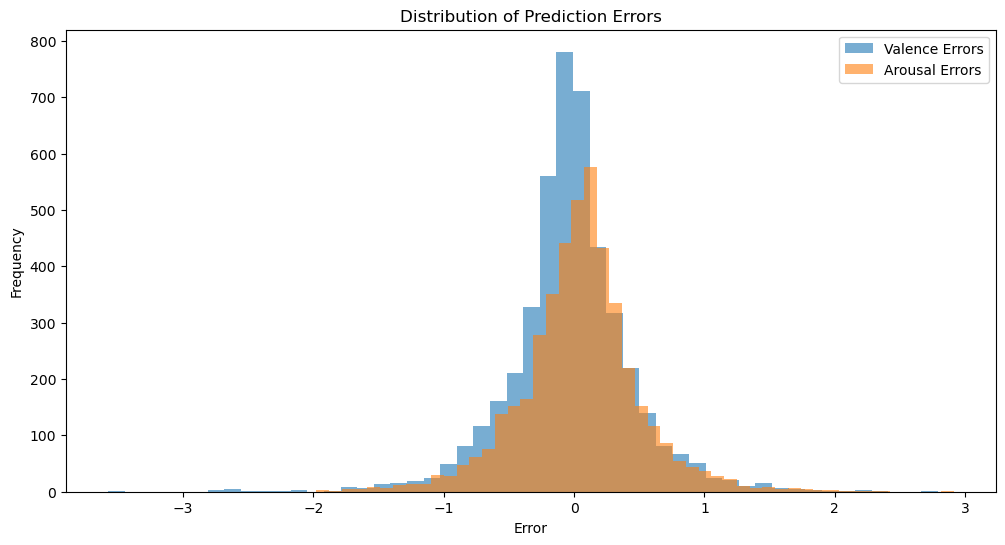

In [22]:
# Calculating the errors
valence_errors = y_pred[:, 0] - y_test[:, 0]
arousal_errors = y_pred[:, 1] - y_test[:, 1]

plt.figure(figsize=(12, 6))
plt.hist(valence_errors, bins=50, alpha=0.6, label='Valence Errors')
plt.hist(arousal_errors, bins=50, alpha=0.6, label='Arousal Errors')
plt.title('Distribution of Prediction Errors')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.legend()
plt.show()

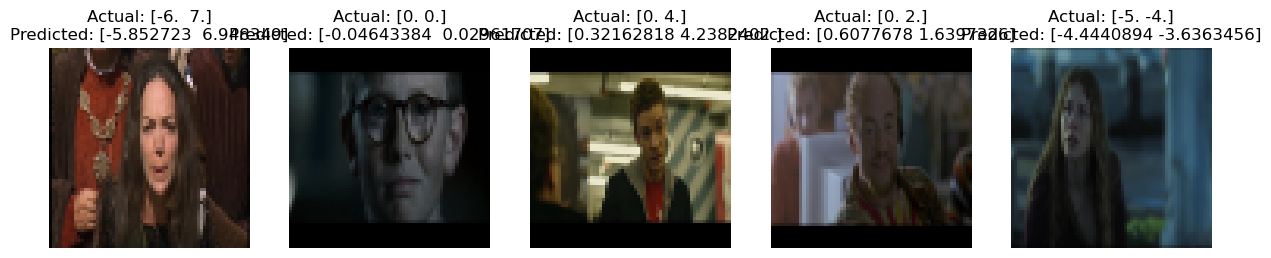

In [23]:
# Choose a few random images
indices = np.random.choice(len(X_test), 5)

plt.figure(figsize=(15, 10))
for i, index in enumerate(indices, 1):
    plt.subplot(1, 5, i)
    plt.imshow(X_test[index])
    plt.title(f"Actual: {y_test[index]}\nPredicted: {y_pred[index]}")
    plt.axis('off')

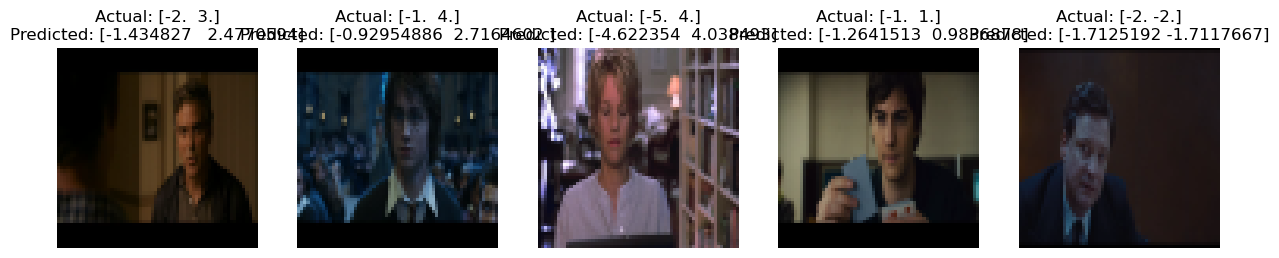

In [24]:
# Choose a few random images
indices = np.random.choice(len(X_test), 5)

plt.figure(figsize=(15, 10))
for i, index in enumerate(indices, 1):
    plt.subplot(1, 5, i)
    plt.imshow(X_test[index])
    plt.title(f"Actual: {y_test[index]}\nPredicted: {y_pred[index]}")
    plt.axis('off')

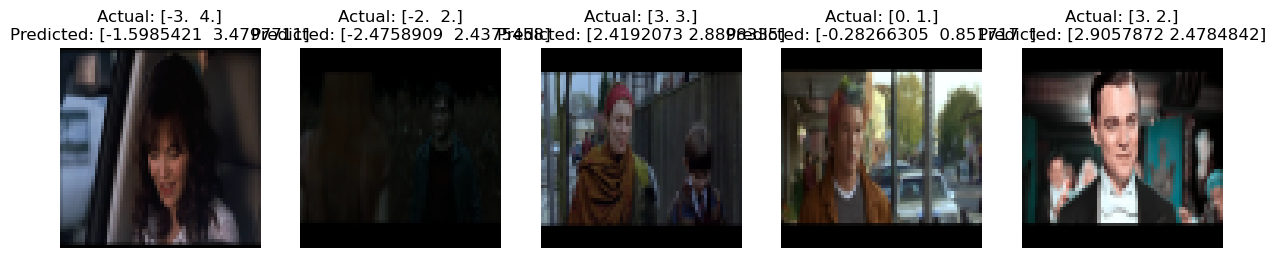

In [30]:
# Choose a few random images
indices = np.random.choice(len(X_test), 5)

plt.figure(figsize=(15, 10))
for i, index in enumerate(indices, 1):
    plt.subplot(1, 5, i)
    plt.imshow(X_test[index])
    plt.title(f"Actual: {y_test[index]}\nPredicted: {y_pred[index]}")
    plt.axis('off')

In [27]:
from tensorflow.keras.models import load_model

loaded_model = load_model(model_path)

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 6, 6, 128)         0